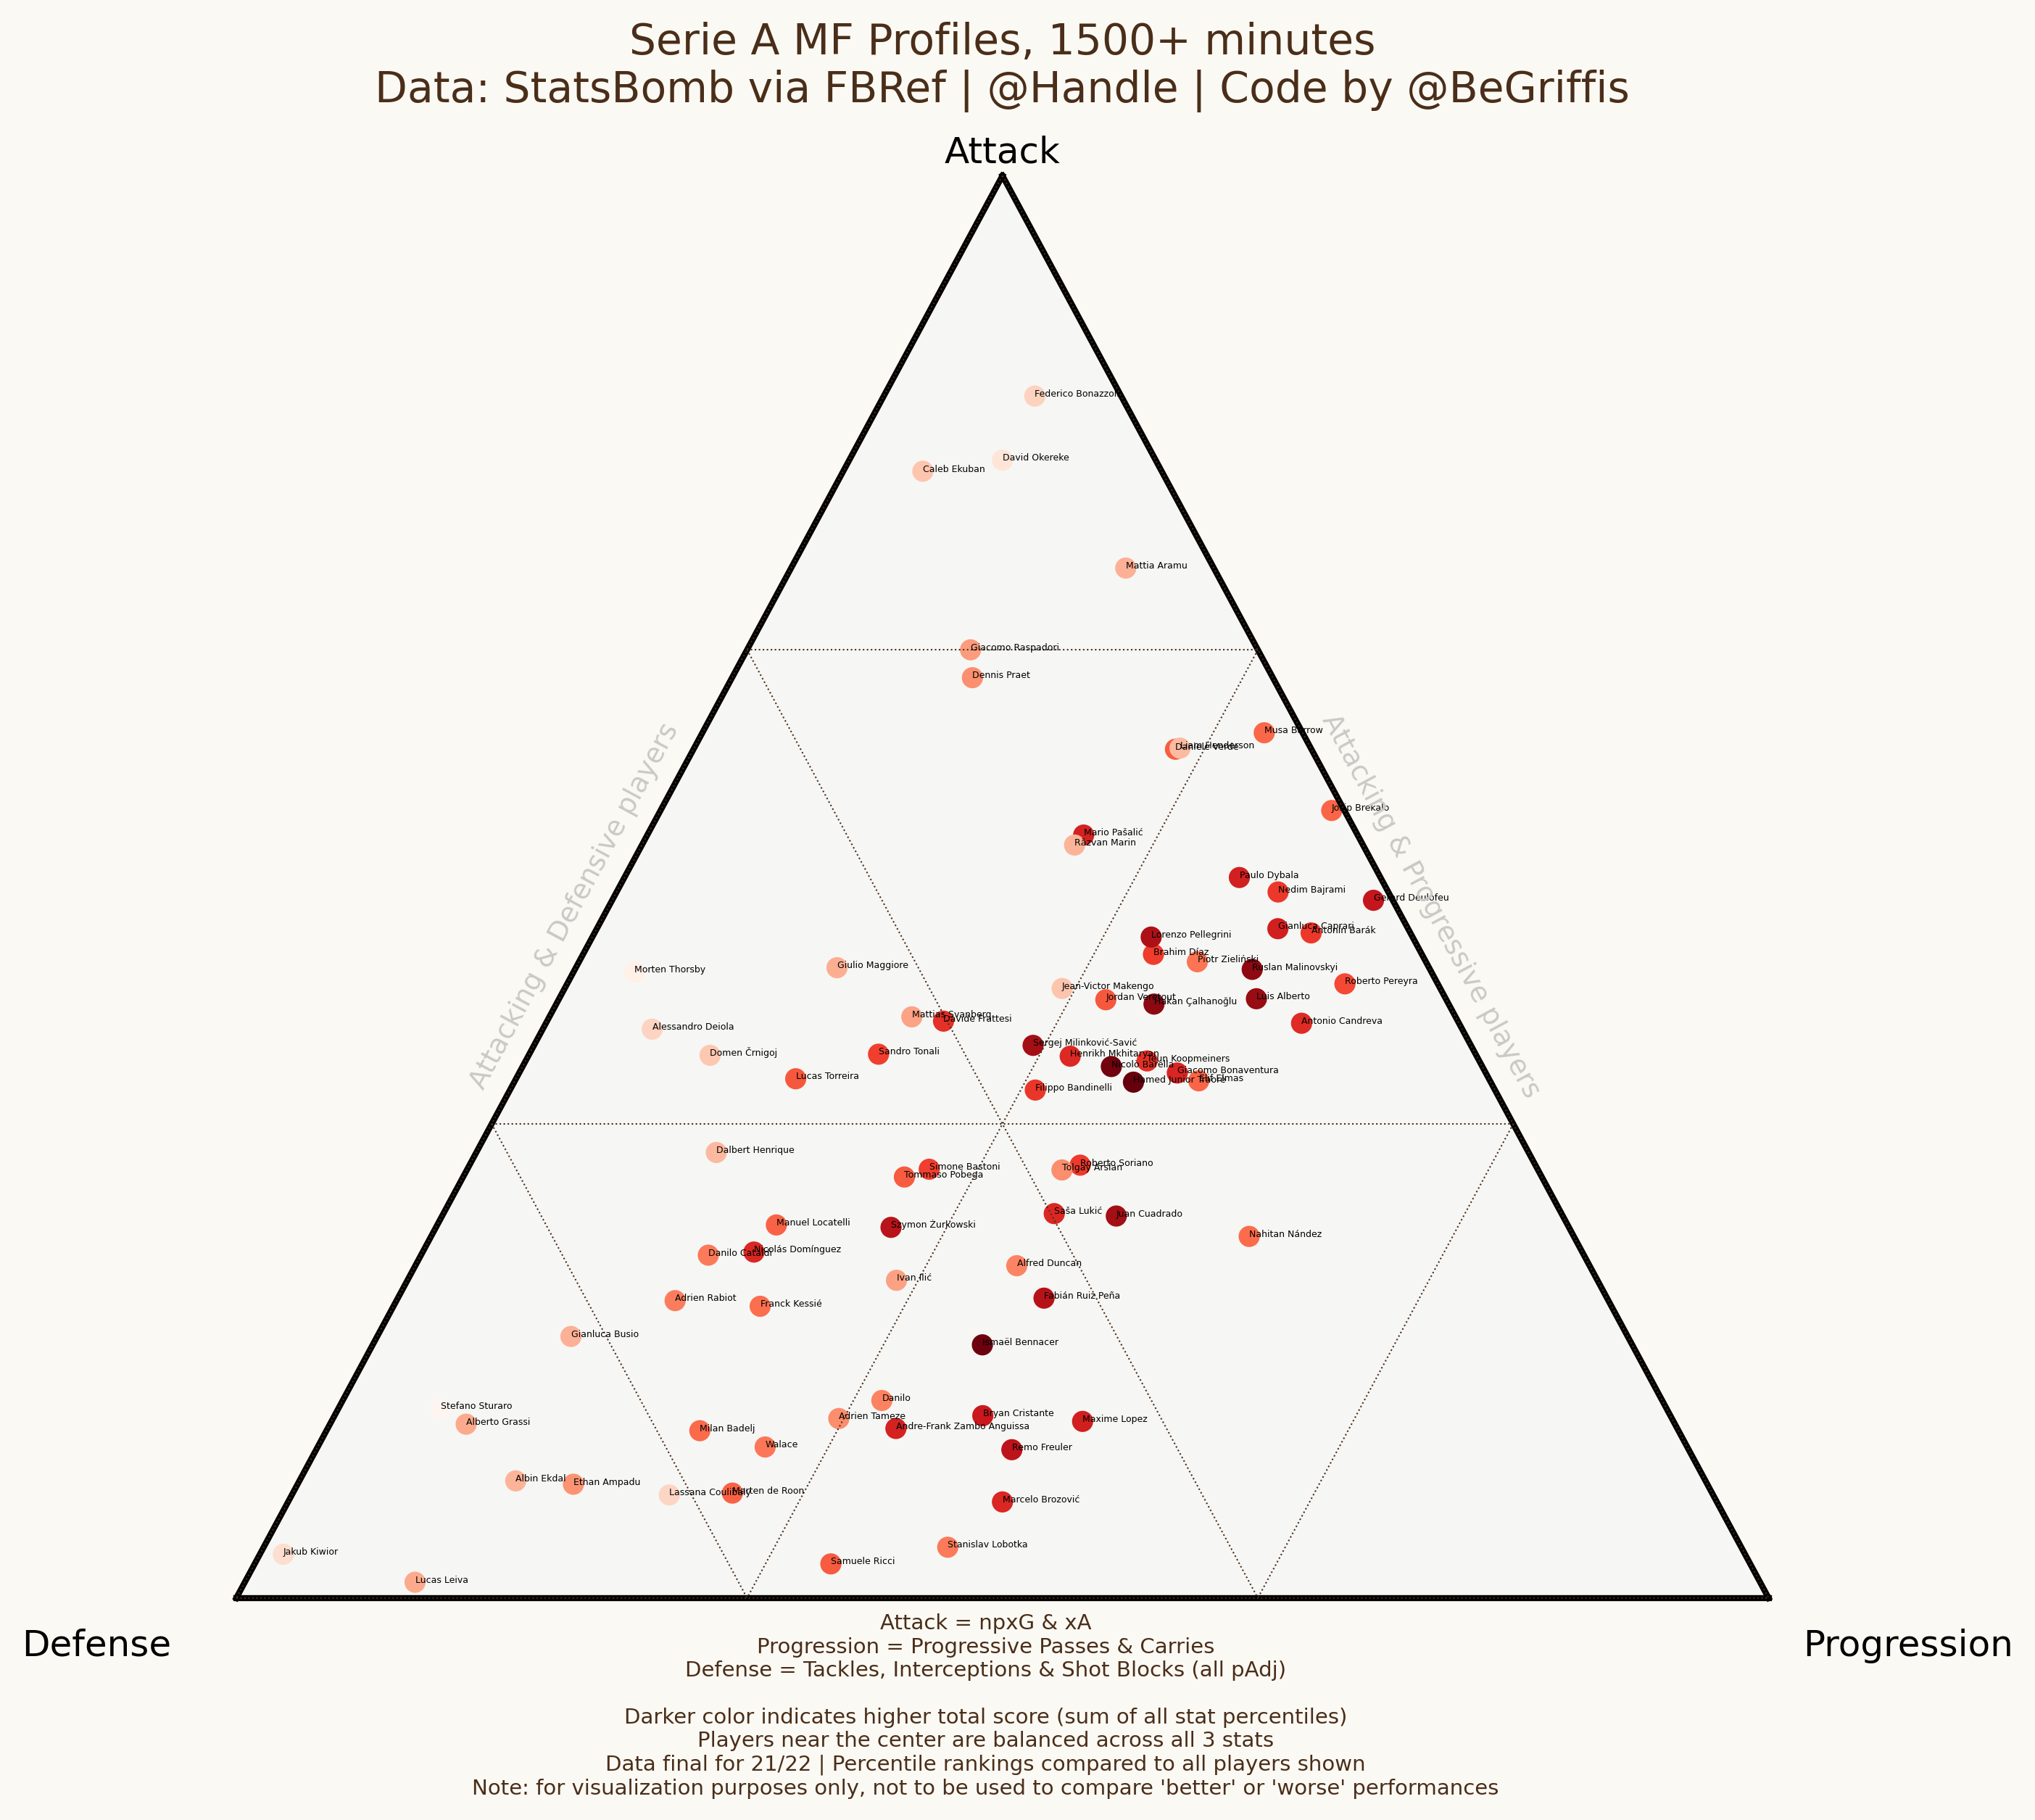

In [1]:
# https://github.com/marcharper/python-ternary
# This is the package I use for this code. Check it out for other cool ways to use Ternary plots!!

import ternary
import matplotlib
import random
import pandas as pd
import numpy as np
from scipy import stats
from statistics import mean
import matplotlib.pyplot as plt
import os
from pathlib import Path

# this is the file path root, i.e. where this file is located
root = str(Path(os.getcwd()).parents[0]).replace('\\','/')+'/'

matplotlib.rcParams['figure.dpi'] = 300 #This sets the quality of the image. To save time I use 300 for getting them riht, and the 2000 for when I want to save it to show on twitter
matplotlib.rcParams['figure.figsize'] = (10, 10) # I like 10 inches x 10 inches personally. But feel free to change it

############# Set your variables here!

final_nongk = 'Final FBRef'     # File name for the final player dataset, created by the FBRef download file
final_gk = 'Final FBRef GK'     # File name for the final GK dataset, created by the FBRef download file

mins = 1500                     # Minutes for filer on
comp = "Serie A"                # League you want to show
pos = 'MF'                      # FBRef positon (I'll update some codes in the future to link with Transfermarkt positions)
sig = '@Handle'                 # Your twitter/website/etc handle

######################################

if pos != 'GK':
    df = pd.read_csv("%s%s.csv" %(root, final_nongk))
else:
    df = pd.read_csv("%s%s.csv" %(root, final_gk))

# This just cleans up FBRef's names of each league
df["Comp"] = df["Comp"].replace("eng Premier League","Premier League")
df["Comp"] = df["Comp"].replace("fr Ligue 1","Ligue 1")
df["Comp"] = df["Comp"].replace("de Bundesliga","Bundesliga")
df["Comp"] = df["Comp"].replace("it Serie A","Serie A")
df["Comp"] = df["Comp"].replace("es La Liga","La Liga")

##################################################
######### Change anything here. If you change the variable names (progression, attack, defense), change them in the 'stat1' variables too
##################################################
df['Progression'] = df['ProgPassesPer90'] + df['ProgCarriesPer90']
df['Attack'] =df['npxGPer90'] + df['xAPer90']
df['Defense'] = df['pAdjTkl+IntPer90'] + df['pAdjShBlocksPer90']

# If you only want to plot a players' ranking in 3 single metrics, comment out the df['Progression'] etc lines,
# and change the variables in 'stat1' etc here to just those 3 variables. I give examples in comments next to them.

stat1 = 'Progression' # npxGPer90
stat2 = 'Attack' # xAPer90
stat3 = 'Defense' # pAdjTkl+IntPer90


df = df[df['Min']>=mins]
df = df[df['Comp']==comp] # IMPORTANT! Comment this line out if you want to visualize players from all top 5 leagues
df = df[df['Pos'].str.contains(pos)]
df = df.reset_index()

# I'm keeping in this info here, but commenting it out. This is the logic you would use to show only certain teams' players
# If you only want to see a few teams' players, also comment out the competition line above.

# df = df[
#     (df['Squad']=='Granada') |
#     (df['Squad']=='Burnley') |
#     (df['Squad']=='Levante') |
#     (df['Squad']=='Arminia') |
#     (df['Squad']=='Alavés') |
#     (df['Squad']=='Cagliari') |
#     (df['Squad']=='Genoa') |
#     (df['Squad']=='Venezia') |
#     (df['Squad']=='Watford') |
#     (df['Squad']=='Norwich City') |
#     (df['Squad']=='Greuther Fürth')
# ]

# This info is needed to create each players' percentile rankings
player_list = list(df['Player'])
team_list = list(df['Squad'])


# Now we can get into actually making the plot! First, initialize some blank dfs
points = []
colors = []

# Now we calculate the percentile rankings of all players individually
for i in range(0,len(df)):
    player_name = player_list[i]
    team = team_list[i]
    
    player = df[(df['Player']==player_name) & (df['Squad']==team)]
    
    x1 = player[stat1].values[0]
    x2 = player[stat2].values[0]
    x3 = player[stat3].values[0]
    pct1 = stats.percentileofscore(df[stat1],x1)
    pct2 = stats.percentileofscore(df[stat2],x2)
    pct3 = stats.percentileofscore(df[stat3],x3)
    
    # This creates the coordinates of the player. Each stat's score as a % of their total score. That's the logic behind ternary plots at their basic form
    pct1_n = pct1/(pct1+pct2+pct3)*100
    pct2_n = pct2/(pct1+pct2+pct3)*100
    pct3_n = pct3/(pct1+pct2+pct3)*100
    
    # The total sum of a player's percentile ranking (out of 300) is their point's color
    col = pct1+pct2+pct3

    # Add each player's info to those blank dfs we initialized above
    points.append((pct1_n,pct2_n,pct3_n))
    colors.append(col)


### Scatter Plot

# I had to play around with mult & scale for a bit to find what worked. If you aren't changing the graph size, no need to change these.
# Read the github package I link in the first line of this code for more info on these
mult = 33.3333333
scale = 100

# Now the figure
figure, tax = ternary.figure(scale=scale)
tax.boundary(linewidth=2.0)
tax.gridlines(multiple=mult, color="#4A2E19")
tax.scatter(points,
            c=colors, cmap='Reds', # Change the 'cmap' if you want to use a different matplotlib color map.
            vmin=min(colors), vmax=max(colors),
            label=player_list,
           )

tax.set_title("%s %s Profiles, %i+ minutes\nData: StatsBomb via FBRef | %s | Code by @BeGriffis" %(comp, pos, mins, sig),
              fontsize=14, color='#4A2E19')
tax.right_corner_label(stat1, fontsize=12, offset=.15)
tax.top_corner_label(stat2, fontsize=12, offset=.125)
tax.left_corner_label(stat3, fontsize=12, offset=.15)
tax.left_axis_label("Attacking & Defensive players", fontsize=9, offset=.05, color='#cac9c5')
tax.right_axis_label("Attacking & Progressive players", fontsize=9, offset=.05, color='#cac9c5')

##### IMPORTANT!! This is the title. You will need to edit it if you change any variables. the '\n', for those who don't know it, adds a new line.
tax.bottom_axis_label("Attack = npxG & xA\nProgression = Progressive Passes & Carries\nDefense = Tackles, Interceptions & Shot Blocks (all pAdj)\n\nDarker color indicates higher total score (sum of all stat percentiles)\nPlayers near the center are balanced across all 3 stats\nData final for 21/22 | Percentile rankings compared to all players shown\nNote: for visualization purposes only, not to be used to compare 'better' or 'worse' performances",
                      fontsize=7, offset=.04,
                     color='#4A2E19')

tax.get_axes().axis('off')

# The fun part... adding player names. Feel free to play around with the font size & color
for i, txt in enumerate(points):
    tax.annotate(player_list[i], points[i], fontsize=3,
                     color='black')

fig = plt.gcf()
fig.set_facecolor('#fbf9f4')
